# Converting SmallNORB into .ngz

If you want to use SmallNORB, you shouldn't need to use this. This is just to convert raw smallnorb into the files needed by the data provider.

In [1]:
import gzip
import numpy as np
import struct
import matplotlib.pyplot as plt
from collections import namedtuple

In [2]:
# Start by cd'ing into smallnorb and running `sh download.sh`
ROOT_DIR = '../scripts/data_munging/smallnorb/data/'
PREFIXES = {
    'train': ROOT_DIR + 'smallnorb-5x46789x9x18x6x2x96x96-training-',
    'test': ROOT_DIR + 'smallnorb-5x01235x9x18x6x2x96x96-testing-',
}

FILE_TYPES = ['info', 'cat', 'dat']

SUFFIX = '.mat'

In [3]:
Header = namedtuple('Header', ['dtype', 'shape', 'tell', 'filename'])

In [4]:
def size_from_int_type(dtype):
    return dtype(0).itemsize

data_type_from_header = {
    '1e3d4c55': np.uint8,
    '1e3d4c54': np.int32,
}

data_desc_to_details = {}

# Header magic numbers
number_count = 6  # number of int32s to read
size_of_i = 4  # bytes in an int32
header_size = size_of_i * number_count

for dataset, prefix in PREFIXES.items():
    for filetype in FILE_TYPES:
        filename = prefix + filetype + SUFFIX
        with open(filename, 'rb') as f:
            magic_num, = struct.unpack('i', f.read(size_of_i))
            data_type = data_type_from_header[format(magic_num, '02x')]

            ndim, = struct.unpack('i', f.read(size_of_i))
            
            # Read at least 3 ints, or however many dims there are
            shape = []
            for i in range(max(ndim, 3)):
                shape_i, = struct.unpack('i', f.read(size_of_i))
                shape.append(shape_i)
            
            # But then take at most n_dim dims
            shape = shape[:ndim]
    
            data_desc_to_details[(dataset, filetype)] = Header(
                dtype=data_type, 
                shape=shape, 
                tell=f.tell(),
                filename=filename,
            )
        
print('\n'.join(map(str, data_desc_to_details.items())))

(('train', 'info'), Header(dtype=<class 'numpy.int32'>, shape=[24300, 4], tell=20, filename='../scripts/data_munging/smallnorb/data/smallnorb-5x46789x9x18x6x2x96x96-training-info.mat'))
(('train', 'cat'), Header(dtype=<class 'numpy.int32'>, shape=[24300], tell=20, filename='../scripts/data_munging/smallnorb/data/smallnorb-5x46789x9x18x6x2x96x96-training-cat.mat'))
(('train', 'dat'), Header(dtype=<class 'numpy.uint8'>, shape=[24300, 2, 96, 96], tell=24, filename='../scripts/data_munging/smallnorb/data/smallnorb-5x46789x9x18x6x2x96x96-training-dat.mat'))
(('test', 'info'), Header(dtype=<class 'numpy.int32'>, shape=[24300, 4], tell=20, filename='../scripts/data_munging/smallnorb/data/smallnorb-5x01235x9x18x6x2x96x96-testing-info.mat'))
(('test', 'cat'), Header(dtype=<class 'numpy.int32'>, shape=[24300], tell=20, filename='../scripts/data_munging/smallnorb/data/smallnorb-5x01235x9x18x6x2x96x96-testing-cat.mat'))
(('test', 'dat'), Header(dtype=<class 'numpy.uint8'>, shape=[24300, 2, 96, 96]

[[209 209 209 ..., 209 209 209]
 [209 209 209 ..., 209 209 209]
 [209 209 209 ..., 209 209 209]
 ..., 
 [208 209 209 ..., 209 209 209]
 [209 209 209 ..., 209 209 209]
 [209 209 209 ..., 209 209 209]]


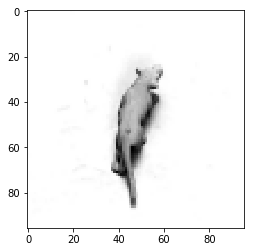

In [5]:
# print an image

header = data_desc_to_details[('train', 'dat')]

im_x, im_y = header.shape[2:4]
size_of_int = size_from_int_type(header.dtype)

with open(header.filename, 'rb') as f:
    f.seek(header.tell)  # skip the header
    f.seek(header.tell + 96 * 96 * 10)  # skip the header
    
    data = np.fromfile(f, dtype=header.dtype, count=(im_x * im_y)).reshape(im_x, im_y)
    data = np.array(data).reshape(im_x, im_y)
    print(data)

plt.imshow(data, cmap='gray')
plt.show()

In [6]:
header = data_desc_to_details[('train', 'info')]

size_of_int = size_from_int_type(header.dtype)

with open(header.filename) as f:
    f.seek(header.tell)  # skip the header
    data = np.fromfile(f, dtype=header.dtype, count=np.prod(header.shape)).reshape(header.shape)
print(data)

[[ 8  6  4  4]
 [ 8  2  6  4]
 [ 4  8 24  3]
 ..., 
 [ 9  5 22  0]
 [ 6  6 10  2]
 [ 6  6 30  0]]


## Save the npz

In [7]:
loaded_data = {}

for key in data_desc_to_details:
    header = data_desc_to_details[key]

    with open(header.filename) as f:
        f.seek(header.tell)  # skip the header
        data = np.fromfile(f, dtype=header.dtype, count=np.prod(header.shape)).reshape(header.shape)

    loaded_data[key] = data
    print(key, data.shape)

('train', 'info') (24300, 4)
('train', 'cat') (24300,)
('train', 'dat') (24300, 2, 96, 96)
('test', 'info') (24300, 4)
('test', 'cat') (24300,)
('test', 'dat') (24300, 2, 96, 96)


In [8]:
# Split test data into validation and test set

raw_cat_data = loaded_data[('test', 'cat')]   
raw_info_data = loaded_data[('test', 'info')]
raw_dat_data = loaded_data[('test', 'dat')]

val_info = raw_info_data[raw_info_data[:, 0] >= 3]
val_targets = raw_cat_data[raw_info_data[:, 0] >= 3]
print(val_targets.shape)
val_inputs = raw_dat_data[raw_info_data[:, 0] >= 3]
print(val_inputs.shape)


test_info = raw_info_data[raw_info_data[:, 0] < 3]
test_targets = raw_cat_data[raw_info_data[:, 0] < 3]
test_inputs = raw_dat_data[raw_info_data[:, 0] < 3]
print(test_targets.shape)
print(test_inputs.shape)

(9720,)
(9720, 2, 96, 96)
(14580,)
(14580, 2, 96, 96)


In [9]:
centered_per_item = {}
with open('../scripts/data_munging/smallnorb/centered-azimith.txt') as f:
    for line in f:
        class_id, instance_id, centered = map(int, line.split(','))
        centered_per_item[(class_id, instance_id)] = centered

def center_given_azimith(azimith, center):
    return ((36 + azimith - center) % 36) * 10

  
def get_centered_azimiths(info, cat):
    return np.vstack(
        (class_id, center_given_azimith(azimith, centered_per_item[class_id, instance]))
        for (instance, _, azimith, _), class_id in zip(info, cat)
    )

train_inputs =  loaded_data[('train', 'dat')]
train_info = loaded_data[('train', 'info')]
train_targets = loaded_data[('train', 'cat')]

mtl_train_targets = get_centered_azimiths(train_info, train_targets)    
mtl_val_targets = get_centered_azimiths(val_info, val_targets)
mtl_test_targets = get_centered_azimiths(test_info, test_targets)

In [10]:
#np.savez_compressed('/Users/jessica/Downloads/' + 'smallnorb-mtl-20180309-train.npz', inputs=train_inputs, targets=mtl_train_targets)
#np.savez_compressed('/Users/jessica/Downloads/' + 'smallnorb-mtl-20180309-valid.npz', inputs=val_inputs, targets=mtl_val_targets)
#np.savez_compressed('/Users/jessica/Downloads/' + 'smallnorb-mtl-20180309-test.npz', inputs=test_inputs, targets=mtl_test_targets)

In [11]:
all_dat = np.vstack((loaded_data[('train', 'dat')], loaded_data[('test', 'dat')]))
all_info = np.vstack((loaded_data[('train', 'info')], loaded_data[('test', 'info')]))
all_targets = np.hstack((loaded_data[('train', 'cat')], loaded_data[('test', 'cat')]))
all_mtl_targets = np.vstack((mtl_train_targets, mtl_val_targets, mtl_test_targets))

example_lookup = {}

for i, (info, target) in enumerate(zip(all_info, all_targets)):
    example_lookup[tuple(list(info) + [target])] = i

print(all_dat.shape)
print(all_info.shape)
print(all_targets.shape)
print(all_mtl_targets.shape)

(48600, 2, 96, 96)
(48600, 4)
(48600,)
(48600, 2)


In [12]:
from ipywidgets import interact

ix_to_label = [
    'animals',
    'human figures',
    'airplanes',
    'trucks',
    'cars',
]

elevations = list(range(30, 72, 5))

def draw_image(category, instance, elevation, azimith, lighting, camera_b):
    camera = 1 if camera_b else 0
    
    example_id = (
        instance,  # instance
        elevation,
        azimith, 
        lighting, 
        category,
    )
    
    print(example_id)
    example = example_lookup[example_id]
    
    plt.imshow(all_dat[example, camera, ::2, ::2], cmap='gray')
    plt.show()
    print(example)
    print(ix_to_label[all_targets[example]])
    print('example?', all_info[example][0])
    print('elevation?', elevations[all_info[example][1]])
    print('azimith?', all_info[example][2] * 10)
    print('lighting?', all_info[example][3])   

    print('centered azimith', all_mtl_targets[example][1])
    print('offset',  centered_per_item[all_mtl_targets[example][0], all_info[example][0]])

interact(
    draw_image,
    category=(0, 4),    
    instance=(0, 9),
    elevation=(0, 8),
    azimith=(0, 34, 2),
    lighting=(0, 5),
    camera_b=False,    
)

interactive(children=(IntSlider(value=2, description='category', max=4), IntSlider(value=4, description='instance', max=9), IntSlider(value=4, description='elevation', max=8), IntSlider(value=16, description='azimith', max=34, step=2), IntSlider(value=2, description='lighting', max=5), Checkbox(value=False, description='camera_b'), Output()), _dom_classes=('widget-interact',))

<function __main__.draw_image>

In [13]:
from ipywidgets import interact

ix_to_label = [
    'animals',
    'human figures',
    'airplanes',
    'trucks',
    'cars',
]

elevations = list(range(30, 72, 5))

def draw_image(instance, class_id):
    camera = 0
        
    example_id = (
        instance,  # instance
        0,
        centered_per_item[class_id, instance], 
        0, 
        class_id,
    )
    
    print(example_id)
    example = example_lookup[example_id]
    
    plt.imshow(all_dat[example, camera, ::2, ::2], cmap='gray')
    plt.show()


interact(
    draw_image,
    instance=(0, 9),
    class_id=(0, 4),
)

interactive(children=(IntSlider(value=4, description='instance', max=9), IntSlider(value=2, description='class_id', max=4), Output()), _dom_classes=('widget-interact',))

<function __main__.draw_image>

In [14]:
NUM_PER_ROW = 5
IMAGE_WIDTH = 96
IMAGE_CHANNELS = 1
BORDER_WIDTH = 1

plt.figure(figsize=(10, 10))

ix_to_label = [
    'animals',
    'human figures',
    'airplanes',
    'trucks',
    'cars',
]

BATCH_SIZE = len(ix_to_label) * NUM_PER_ROW  # a heuristic so we pull down enough images

train_inputs = loaded_data[('train', 'dat')]

# This actually builds a the list of examples to show
input_to_show = []
for i, label in enumerate(ix_to_label):
    row = []
    for j in range(NUM_PER_ROW):
        row.append(
            train_inputs[example_lookup[(8, 3, (2 * j + 24) % 34, 2, i)]]
        )
    input_to_show.append(row)


# create a canvas with NUM_PER_ROW examples per row, and a few columns
canvas = np.zeros((
    BORDER_WIDTH + (IMAGE_WIDTH + BORDER_WIDTH) * len(ix_to_label),
    BORDER_WIDTH + (IMAGE_WIDTH + BORDER_WIDTH) * NUM_PER_ROW, 
))

for label_i, examples in enumerate(input_to_show):
    for example_i, (example, target) in enumerate(examples):
        start_x = BORDER_WIDTH + label_i * (IMAGE_WIDTH + BORDER_WIDTH)
        start_y = BORDER_WIDTH + example_i * (IMAGE_WIDTH + BORDER_WIDTH)
        
        canvas[
            start_x:start_x + IMAGE_WIDTH, 
            start_y:start_y + IMAGE_WIDTH,
        ] = example.reshape(IMAGE_CHANNELS, IMAGE_WIDTH, IMAGE_WIDTH)

canvas = 1 - canvas
plt.imshow(canvas, cmap='Greys')

# Some layout things
plt.axis('off')
plt.tight_layout()
plt.savefig('smallNORB.png')

#plt.show()